# COGS 108 - Final Project 

# Overview

My hypothesis was that restaurants in low income areas are likely to have a higher average number of health code violations per inspection. I used the dataset provided by Wake county website on businesses inspections and income based on zipcodes.  Unlike the linked studies here, I found that there is no relationship between median family income and average number of health code violations per inspection. There could be other underlying issues that needs further study.

# Names & PID

- Name: Ahmad Sadeed
- GitHub Username: ahmadsadeed

# Research Question

Given that, "low-income neighborhoods offered greater access to food sources that promote unhealthy eating" [1], we would like to find if restaurants in low income neighborhoods have higher number of health violations? 

## Background and Prior Work

> Environmental justice is concerned with an equitable distribution of environmental burdens. These burdens comprise immediate health hazards as well as subtle inequities, such as limited access to healthy foods. [1]

There is a relationship between an area's major ethnicities and races and what kind of businesses and quality of services they receive. There have been some studies that, "focus of environmental justice from environmental hazards and toxic exposures to issues of the food environment by examining research on socioeconomic, ethnic, and racial disparities in neighborhood access to fast-food outlets and convenience stores." [1] 

Another study analyzed how, "restaurant inspection frequency and restaurant neighborhood sociodemographic characteristics are related to food safety inspection outcomes in chain and nonchain restaurants." The study suggested that, "public health departments in Philadelphia and elsewhere could consider focusing more of their food safety inspection efforts on nonchain restaurants than on chain restaurants, while applying a lower level of scrutiny to chain restaurants, which have internal food safety protocols and economies of scale that may reduce the likelihood of food safety violations." [2] A different study asks if there is a relationship between socioeconomic status and risk of foodborne illness while knowing that we can predict, using available services, if a community has access to healthy food based on its socioeconomic status. the study  concluded that, "facilities in lower poverty areas, however, had a higher average number of critical health code violations (CHV) per inspection." [3] It also found that, "high concentrations of minority populations found Hispanic facilities had more CHV than other demographics, and Hispanic and African American facilities had fewer days between inspections." [3] However, it summarizes that health inspections might be influenced by other underlying conditions due to its subjective nature.





References (include links):
- 1) [Neighborhood Disparities in Access to Healthy Foods and Their Effects on Environmental Justice](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3482049/)
- 2) [Inspection Frequency, Sociodemographic Factors, and Food Safety Violations in Chain and Nonchain Restaurants, Philadelphia, Pennsylvania, 2013-2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/)
- 3) [Critical Health Code Violations in Retail Facilities](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjJkK2wjPPpAhUWJjQIHTE7BOgQFjANegQIBhAB&url=https%3A%2F%2Fjfoodprotection.org%2Fdoi%2Fpdf%2F10.4315%2F0362-028X.JFP-11-101&usg=AOvVaw0I0yMeM6GIAKsm-UigXLCW)

# Hypothesis


As mentioned in the prior section, we can find out if a community has access to healthy food based on its socioeconomic conditions. My hypothesis is that restaurants in low income areas are likely to have a higher average number of health code violations per inspection. 

# Dataset(s)

We will be using the `inspections.csv` and `zipcodes.csv` files from the provided dataset to answer our question. The `inspections.csv` file has information on each inspection, inspected business name, address, zip code, score, number of critical and non-critical violations, average of previous violations and more. The `zipcodes.csv` has the income, poverty and some race information for most of the zip codes in `inspections.csv`. We will explain in data cleaning section how we use these two datasets together and separately.  
- inspections.csv
- zipcodes.csv


# Setup

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import patsy
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ks_2samp
import json

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7) #increase figure size
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

import shapely.geometry as shp

import seaborn as sns
sns.set(style='white', font_scale=2) #set style

import warnings
warnings.filterwarnings('ignore')


#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Read all datasets 
inspection_df = pd.read_csv('data/inspections.csv')
zipcode_df = pd.read_csv('data/zipcodes.csv')

### Let's look into inspection_df. 

In [3]:
inspection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466 entries, 0 to 18465
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   hsisid                                 18466 non-null  int64  
 1   date                                   18466 non-null  object 
 2   name                                   18466 non-null  object 
 3   address1                               18466 non-null  object 
 4   address2                               1895 non-null   object 
 5   city                                   18466 non-null  object 
 6   state                                  18466 non-null  object 
 7   postalcode                             18466 non-null  object 
 8   phonenumber                            17965 non-null  object 
 9   restaurantopendate                     18466 non-null  object 
 10  days_from_open_date                    18466 non-null  int64  
 11  fa

We have 35 columns in inspection_df but we don't need every column to answer our question.  Let's drop the list of columns that are not too critical for our hypothesis. 

In [4]:

noNeed = ['date','name', 'address1','address2', 'city','state', 'postalcode','phonenumber','restaurantopendate',
          'days_from_open_date','facilitytype', 'x', 'y', 'geocodestatus','type', 'description', 'inspectedby', 
          'inspector_id','previous_inspection_date', 'days_since_previous_inspection',
          'previous_inspection_by_same_inspector','score','num_critical_previous', 'num_non_critical_previous',
          'avg_neighbor_num_critical', 'avg_neighbor_num_non_critical','top_match', 'second_match', 'critical']
inspection_df.drop(noNeed, axis=1, inplace=True)


We have two columns that contain number of critical and non-critical violations for each inspection: `num_critical` and `num_non_critical`. We will add these two numbers and create a **new column using the sum**. We also have two other columns that have the **average** of critical and non-critical violations from total of previous visits: `num_critical_mean_previous` and `num_non_critical_mean_previous`. We will create a new column using the sum of these two columns. 

In [5]:
inspection_df['total_today'] = inspection_df['num_critical'] + inspection_df['num_non_critical']
inspection_df['avg_prev'] = inspection_df['num_critical_mean_previous'] + inspection_df['num_non_critical_mean_previous']

We will create a new column: `avg_violations` by adding `avg_prev` to `total_today` and dividing by 2. The `avg_violations` column will be the average number of violations for this business until and including the last inspection . We will drop the columns that were used to create these new columns.

In [6]:
inspection_df['avg_violations'] = ((inspection_df['avg_prev'] + inspection_df['total_today']) / 2)

In [7]:
noNeed = ['num_critical', 'num_non_critical','num_critical_mean_previous', 
          'num_non_critical_mean_previous','total_today', 'avg_prev']
inspection_df.drop(noNeed, axis=1, inplace=True)

### Filter the Dataframe:
Below, in the output of one random business, we see that this business had 9 inspections in total and we see its average number of violations until and including the inspection of its respective row. For our purpose, we only need the latest average and can safely remove all rows before the last inspection. The value for `avg_violations` for the latest inspection has kept track of averages of all previous inspections.

In [8]:
inspection_df[inspection_df.hsisid == 4092110487]

,hsisid,zip,inspection_num,avg_violations
3606,4092110487,27519,1,NaN
5266,4092110487,27519,2,3.000000
7221,4092110487,27519,3,2.500000
9478,4092110487,27519,4,2.333333
11253,4092110487,27519,5,3.250000
12592,4092110487,27519,6,2.900000
13809,4092110487,27519,7,2.416667
16805,4092110487,27519,8,2.357143
18463,4092110487,27519,9,4.812500


In [9]:
# Get the last row for each business where inspection_num is maximum
inspection_df = inspection_df.loc[inspection_df.reset_index().groupby(['hsisid'])['inspection_num'].idxmax()]
inspection_df

,hsisid,zip,inspection_num,avg_violations
15404,4092010018,27628,6,13.700000
16755,4092010024,27607,11,7.300000
17534,4092010031,27604,4,4.666667
10960,4092010035,27511,3,12.500000
15444,4092010037,27591,5,7.625000
...,...,...,...,...
17380,4092300270,27607,4,6.000000
14742,4092300271,27616,1,NaN
18266,4092300272,27560,1,NaN
17507,4092300273,27591,1,NaN


#### Let's remove rows where `avg_violations` is `NaN`.

In [10]:
inspection_df = inspection_df[~inspection_df.avg_violations.isnull()]

### Let's look into zipcode_df. 

In [11]:
zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   zip                                   38 non-null     int64  
 1   median_family_income_dollars          38 non-null     int64  
 2   median_household_income_dollars       38 non-null     int64  
 3   per_capita_income_dollars             38 non-null     int64  
 4   percent_damilies_below_poverty_line   38 non-null     float64
 5   percent_snap_benefits                 38 non-null     float64
 6   percent_supplemental_security_income  38 non-null     float64
 7   percent_nonwhite                      38 non-null     float64
dtypes: float64(4), int64(4)
memory usage: 2.5 KB


#### As we see above, some of the column names are too long. Let's rename them.

In [12]:
zipcode_df.rename({'median_family_income_dollars': 'family', 'median_household_income_dollars': 'household', 
                   'per_capita_income_dollars': 'per_capita', 'percent_damilies_below_poverty_line': 'below_pov', 
                   'percent_snap_benefits': 'snap', 'percent_supplemental_security_income': 'supplement'}, 
                    axis=1, inplace=True)

In [13]:
zipcode_df.head()

,zip,family,household,per_capita,below_pov,snap,supplement,percent_nonwhite
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9


### Difference Between Household Income, Family Income and Per Capita Income
> Household income considers the incomes of all people ages 15 years or older occupying the same housing unit, regardless of relation. A single person occupying a dwelling by himself is also considered a household. Family income, by contrast, considers only households occupied by two or more people related by birth, marriage or adoption. Per capita income measures the average income earned by each person in a given area. Therefore, two income earners in the same family or household are counted separately when measuring per capita income.

- [Source](https://www.investopedia.com/terms/h/household_income.asp)

We will drop `per_capita`, `snap` and `supplement` columns to focus on certain measures of income. We will choose between below poverty percentage, median family income and median household income to compare low income zipcodes with average number of health violations. 

In [14]:
noNeed = ['per_capita', 'snap','supplement']
zipcode_df.drop(noNeed, axis=1, inplace=True)

We will use Kolmogorov-Smirnov test to compare the distributions of two columns: median family income and median household income. Later, we will also use information on percentage of people below poverty line, `below_pov` column, to do some analysis.  

In [15]:
# imported from scipy.stats
ks_2samp(zipcode_df.family, zipcode_df.household)

Ks_2sampResult(statistic=0.34210526315789475, pvalue=0.022739454176368187)

For the above, with `alpha=0.05`, our **null hypothesis would be that there is no difference between the two income measures**: `zipcode_df.family` and  `zipcode_df.household`. We get a p-value of `pvalue=0.0227` and we have to reject the null hypothesis. Therefore, the two columns have different distributions. We will use median family income in this analysis.

### Merge the two dataframes

First we will merge `inspection_df` and `zipcode_df` based `on='zip'` using `how='left'` to inspect what zipcodes from `inspection_df` are not listed on `zipcode_df` and check if it is okay to drop rows (use inner join instead of left join) in `inspection_df` that are missing from `zipcode_df` because we won't have information about their income. We will find out that there some rows whose zip codes and income is not listed in `zipcode_df`.

In [16]:
df = pd.merge(inspection_df, zipcode_df, how='left', on='zip')

In [17]:
df[df.family.isnull()].groupby('zip').count()['hsisid']

zip
27512     3
27573     1
27579     2
27595     1
27602     7
         ..
27652     1
27695    24
27709     1
28145     1
28587     1
Name: hsisid, Length: 13, dtype: int64

The income information for the missing zip codes from `zipcode_df` has one outlier and is missing at random for most others and therefore, we can merge the two dataframes using inner join resulting in removing of 45 rows.

In [18]:
df = pd.merge(inspection_df, zipcode_df, how='inner', on='zip')

### Check for Missing Values

In [19]:
print('Shape of df:', df.shape)
print('Shape of missing values:', df[df.isnull().any(axis=1)].shape)

Shape of df: (2783, 8)
Shape of missing values: (0, 8)


# Data Analysis & Results

In [20]:
df

,hsisid,zip,inspection_num,avg_violations,family,household,below_pov,percent_nonwhite
0,4092010024,27607,11,7.300000,85325,53825,12.8,25.0
1,4092010490,27607,8,6.214286,85325,53825,12.8,25.0
2,4092010500,27607,6,8.600000,85325,53825,12.8,25.0
3,4092010617,27607,8,11.785714,85325,53825,12.8,25.0
4,4092010699,27607,11,3.400000,85325,53825,12.8,25.0
...,...,...,...,...,...,...,...,...
2778,4092016628,27501,6,6.800000,59408,51121,10.5,17.9
2779,4092020932,27596,5,6.000000,68750,59712,5.6,18.9
2780,4092020933,27596,5,2.500000,68750,59712,5.6,18.9
2781,4092020934,27596,5,3.500000,68750,59712,5.6,18.9


### Distribution of some numerical values:
We will see how some of the variables are distributed. We will remove any outliers if it is at random. We will also use numpy's `log` or scipy's `boxcox` to do some transformation to get rid of the skewed distributions. We will also create new columns with transformed data, inplace, if needed.

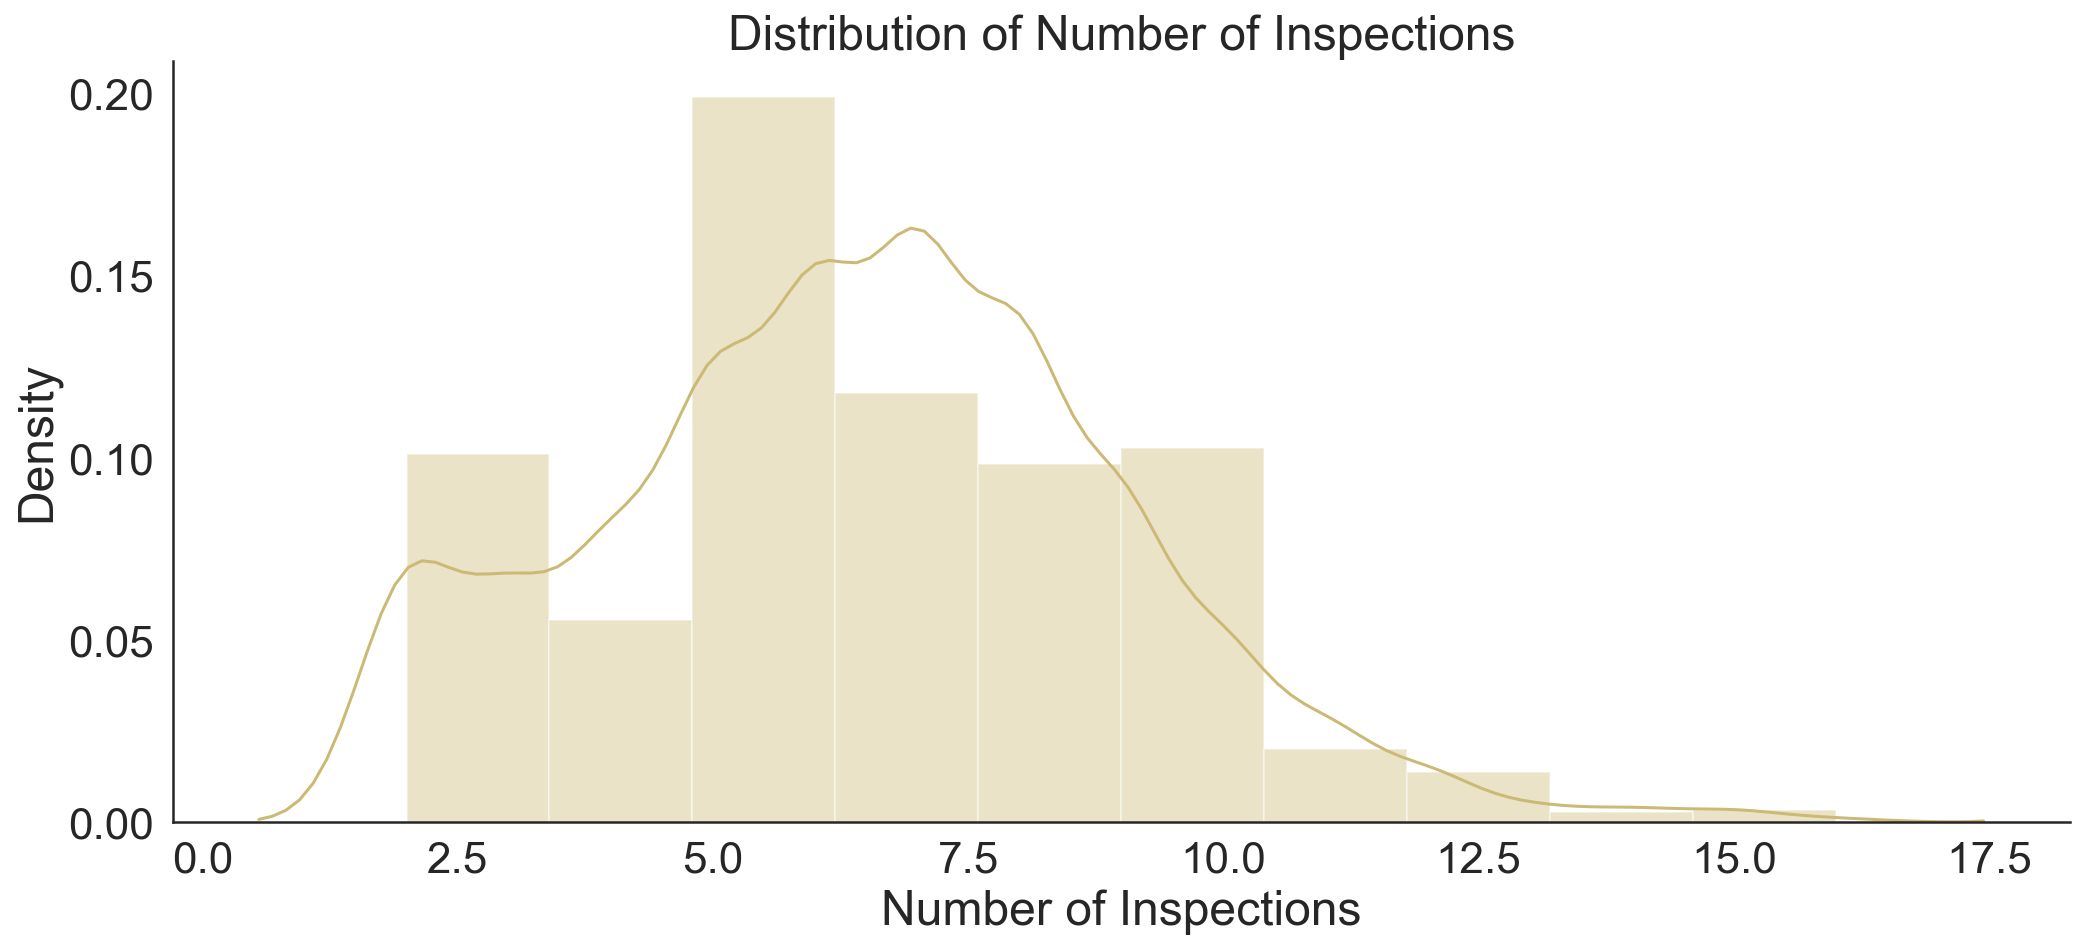

In [21]:
ax = sns.distplot(df.inspection_num, bins=10, color='y')
sns.despine()
ax.set_title('Distribution of Number of Inspections')
ax.set_ylabel('Density')
ax.set_xlabel('Number of Inspections');

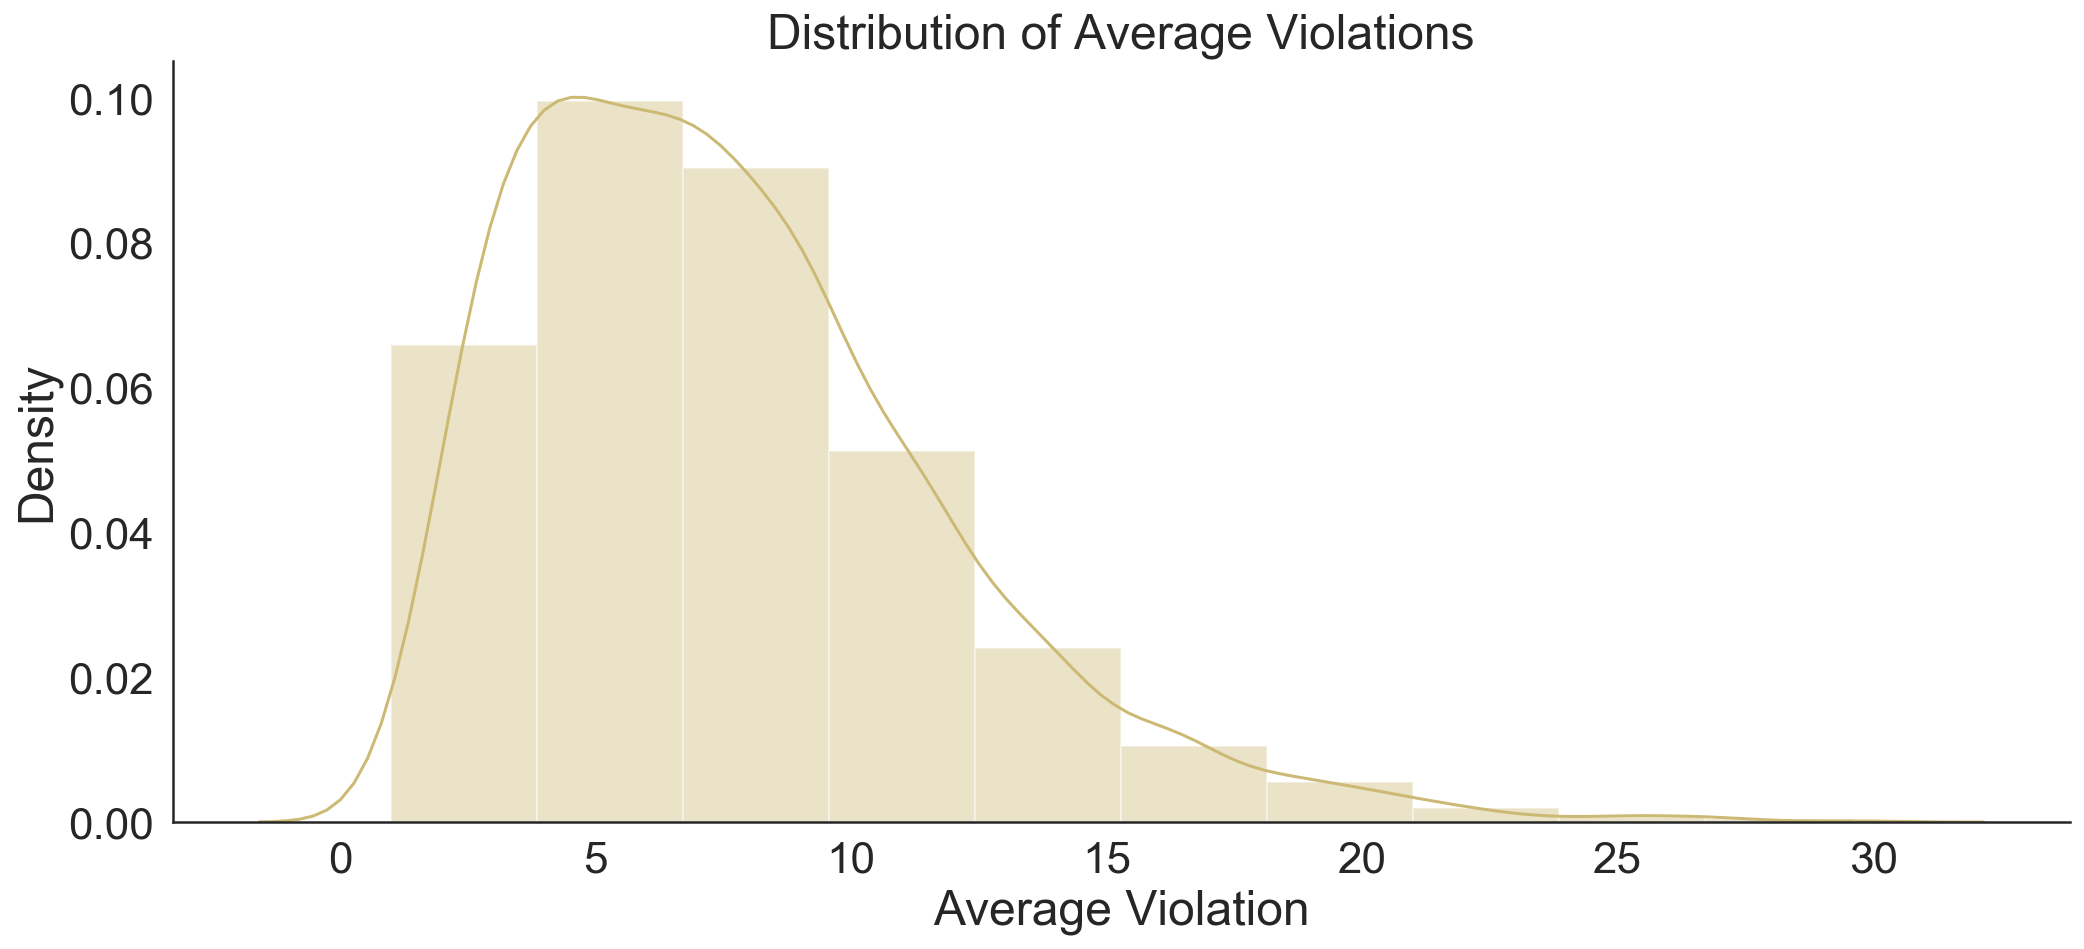

In [22]:
ax = sns.distplot((df.avg_violations), bins=10, color='y')
sns.despine()
ax.set_title('Distribution of Average Violations')
ax.set_ylabel('Density')
ax.set_xlabel('Average Violation');

In [23]:
# see how skewed the data is:
df.avg_violations.skew()

1.0760047660878178

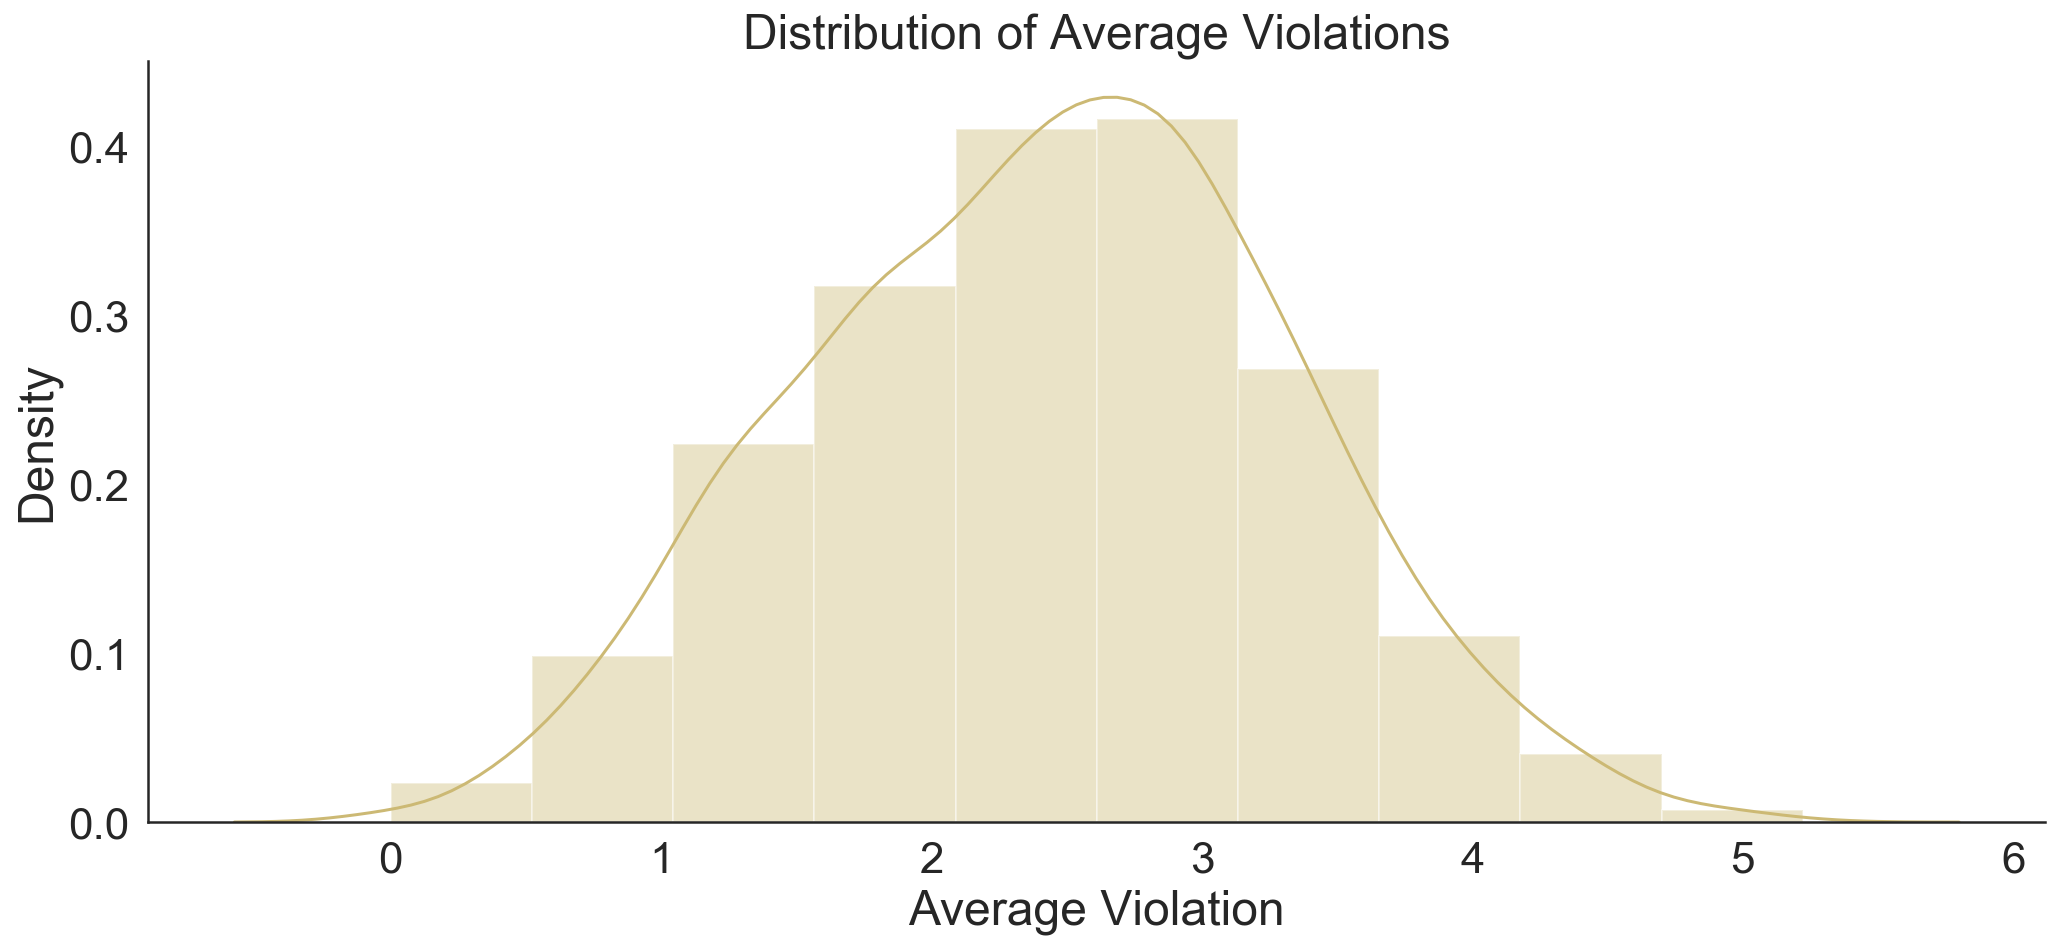

In [24]:
box,x = stats.boxcox(df.avg_violations)
ax = sns.distplot(box, bins=10, color='y')
sns.despine()
ax.set_title('Distribution of Average Violations')
ax.set_ylabel('Density')
ax.set_xlabel('Average Violation');

Above using `boxcox` transformation create a much better distribution. Let's add new column to our data. 

In [25]:
# box,x = stats.boxcox(df.avg_violations)
df['box_avg_violations'] = box

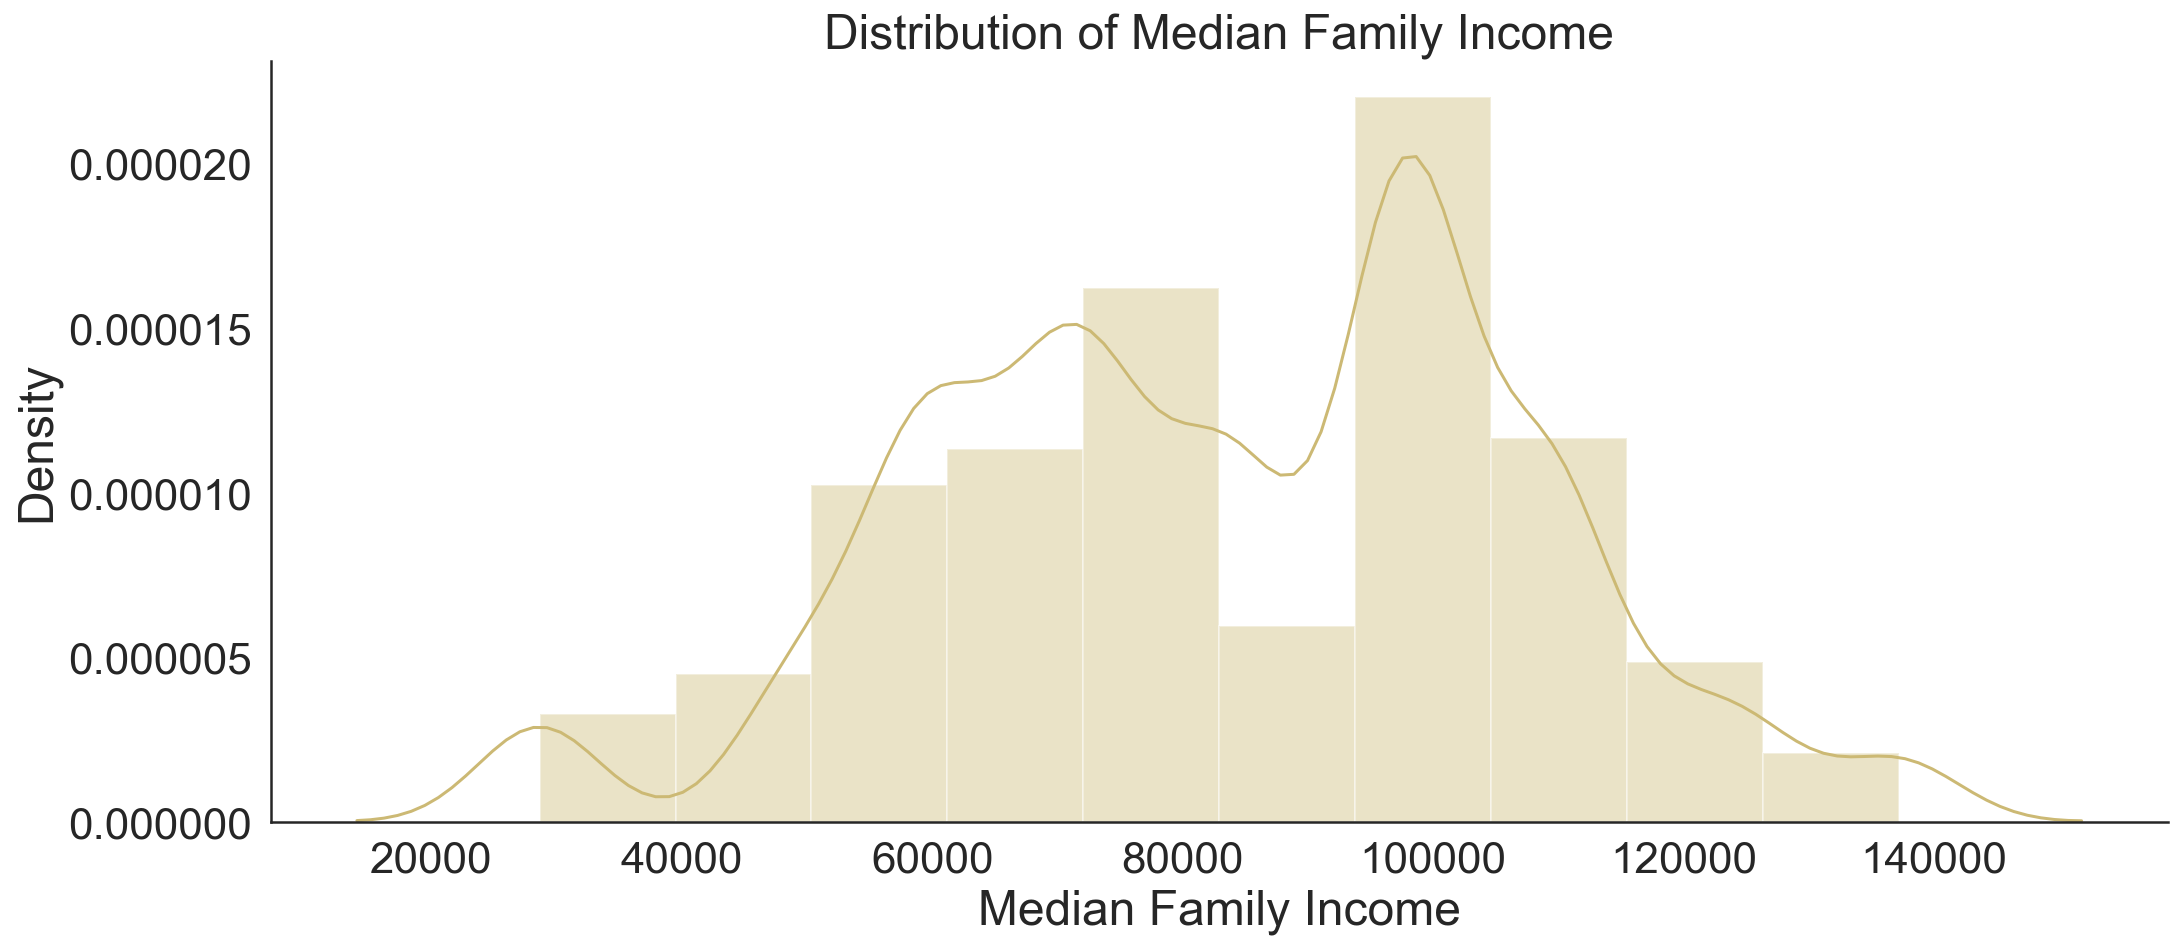

In [26]:
ax = sns.distplot((df.family), bins=10, color='y')
sns.despine()
ax.set_title('Distribution of Median Family Income')
ax.set_ylabel('Density')
ax.set_xlabel('Median Family Income');

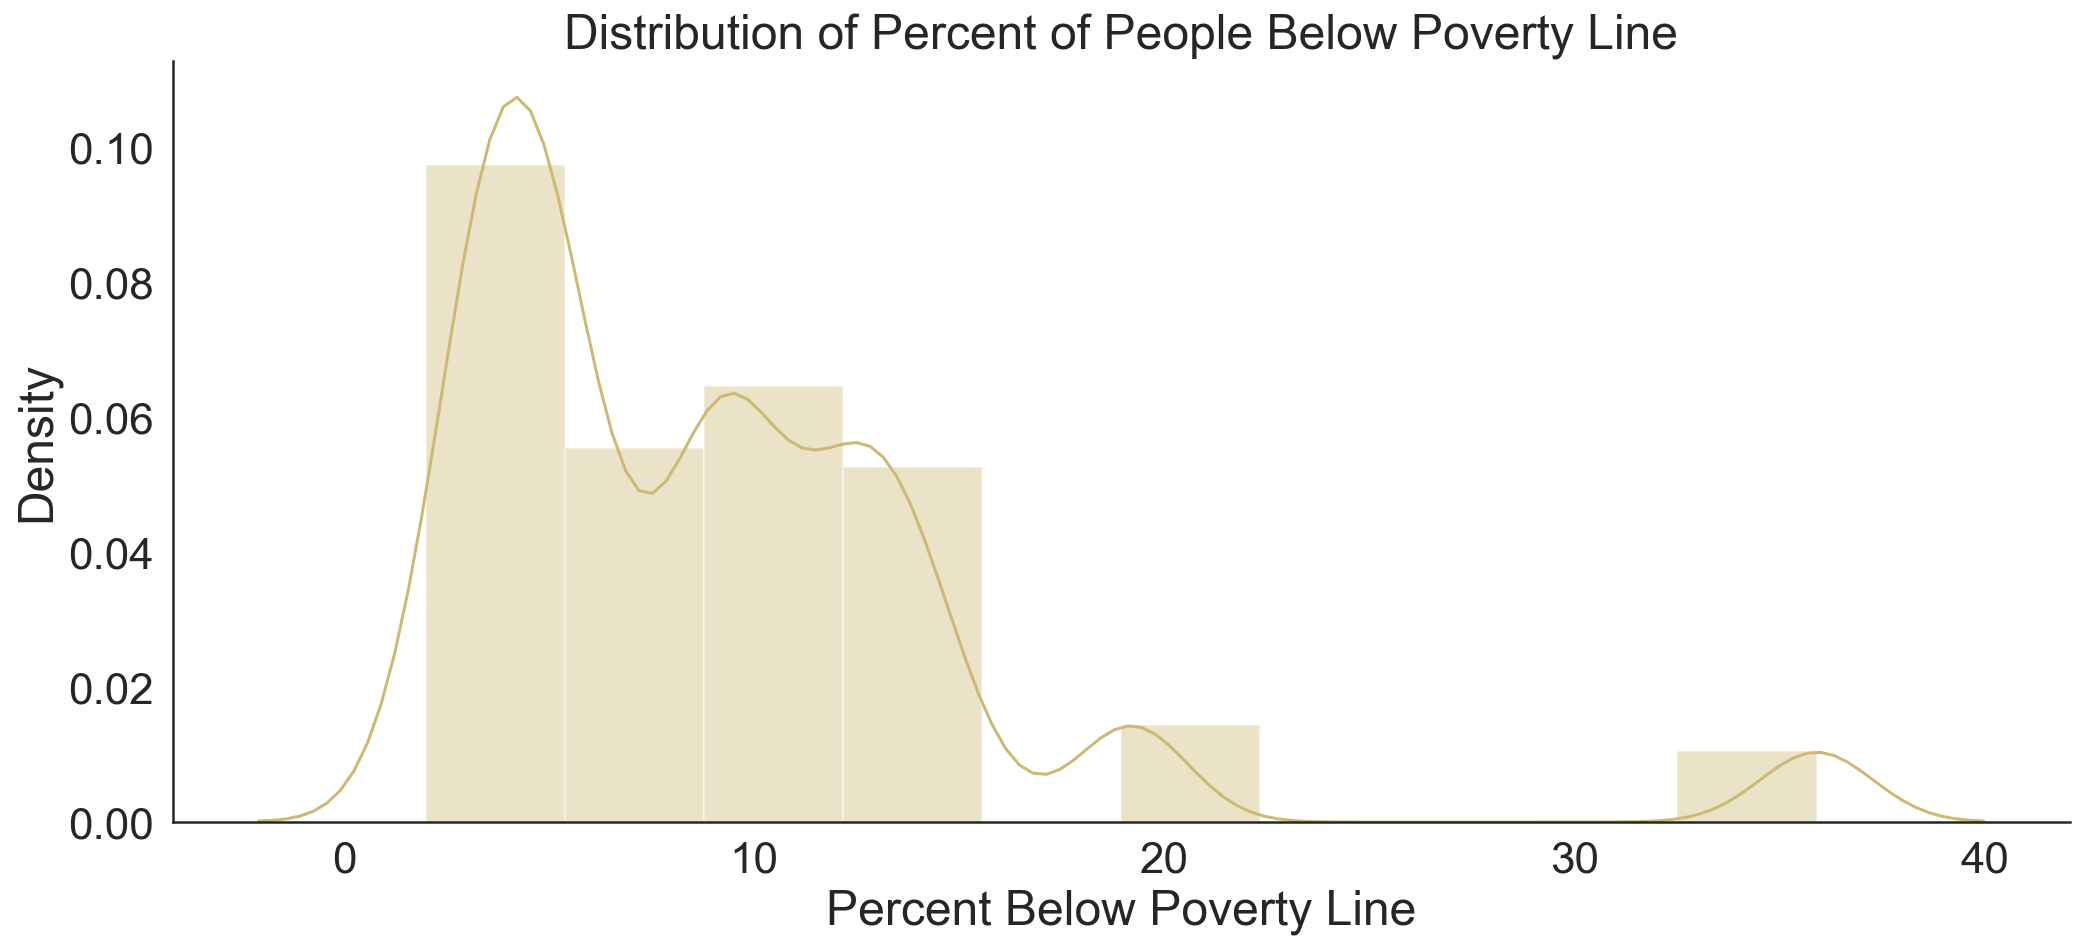

In [27]:
ax = sns.distplot(df.below_pov, bins=10, color='y')
sns.despine()
ax.set_title('Distribution of Percent of People Below Poverty Line')
ax.set_ylabel('Density')
ax.set_xlabel('Percent Below Poverty Line');

Let's transform the data:

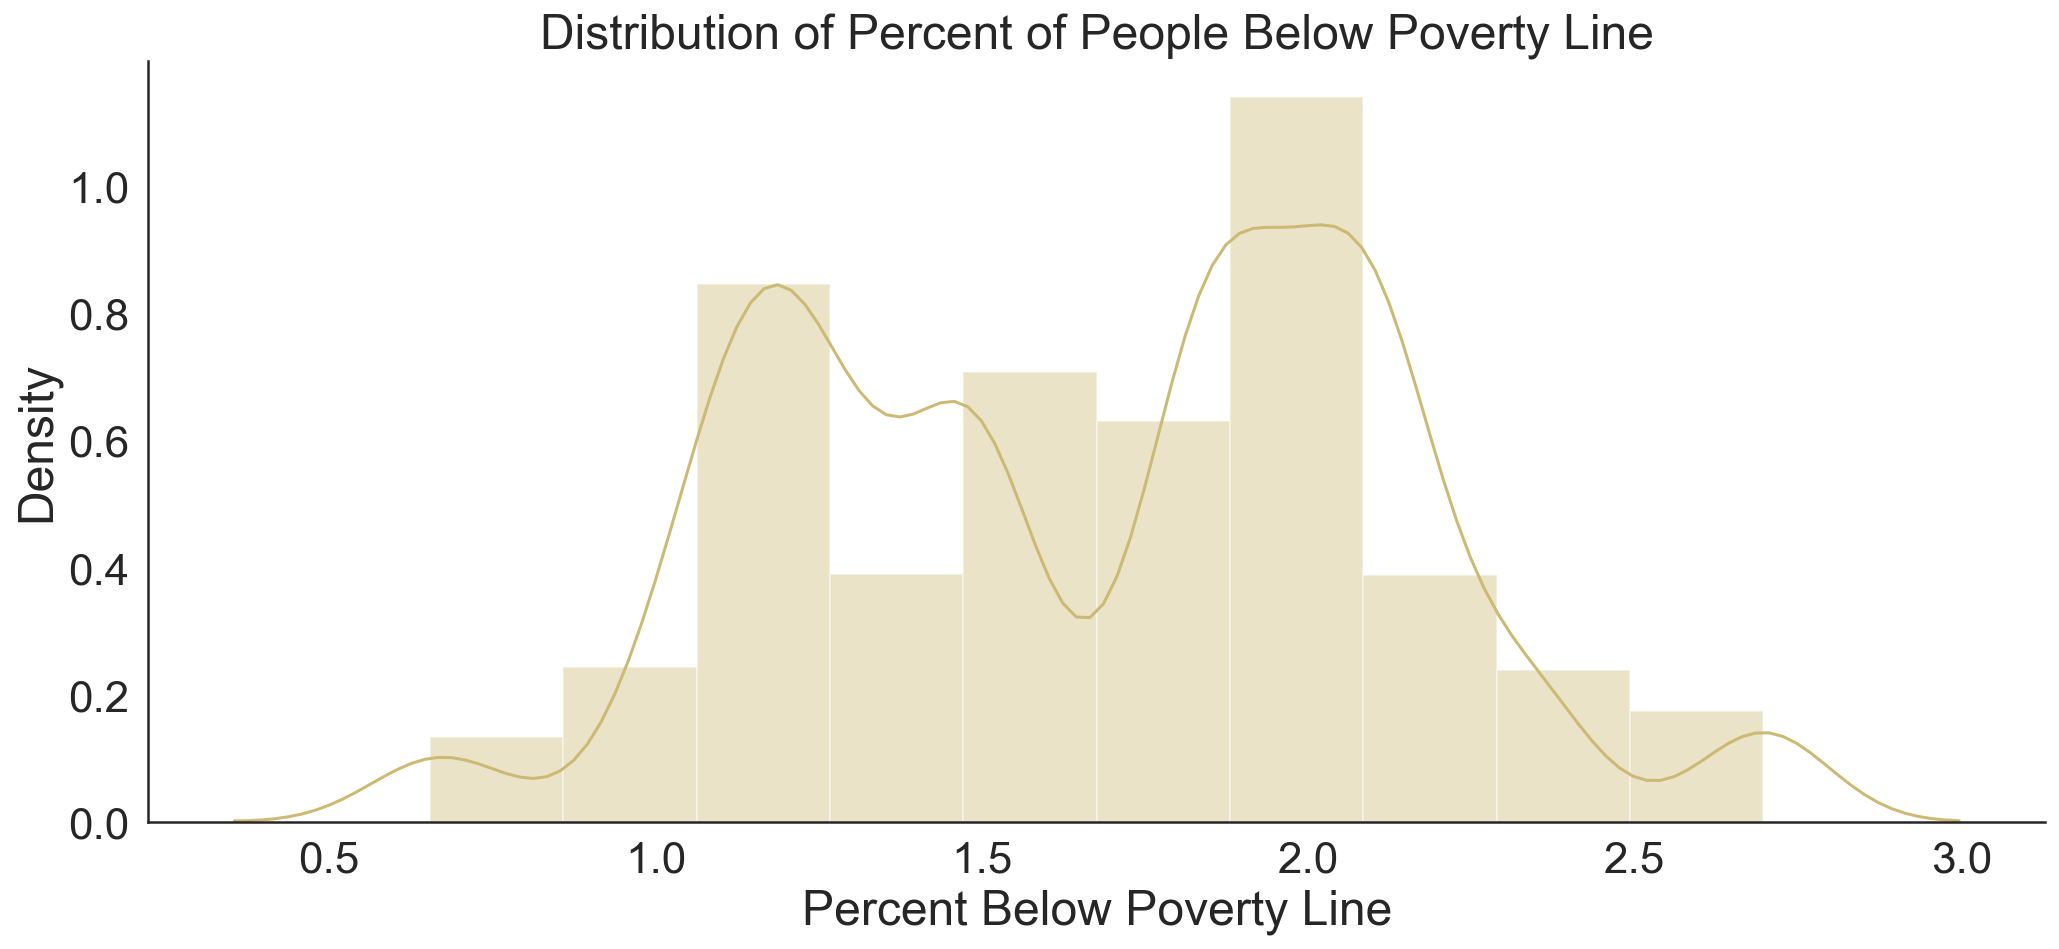

In [28]:
box,x = stats.boxcox(df.below_pov)
ax = sns.distplot(box, bins=10, color='y')
sns.despine()
ax.set_title('Distribution of Percent of People Below Poverty Line')
ax.set_ylabel('Density')
ax.set_xlabel('Percent Below Poverty Line');

In [29]:
box,x = stats.boxcox(df.below_pov)
df['box_below_pov'] = box

In [30]:
df.columns

Index(['hsisid', 'zip', 'inspection_num', 'avg_violations', 'family',
       'household', 'below_pov', 'percent_nonwhite', 'box_avg_violations',
       'box_below_pov'],
      dtype='object')

### Hypothesis, again:
Restaurants in low income areas are likely to have a higher average number of health code violations per inspection. 

#### Null Hypothesis:
There is no relationship between median family income and average number of health code violations per inspection. 

In [31]:
outcome, predictors = patsy.dmatrices('family ~ box_avg_violations', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 family   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1497
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.699
Time:                        18:48:37   Log-Likelihood:                -31972.
No. Observations:                2783   AIC:                         6.395e+04
Df Residuals:                    2781   BIC:                         6.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8.359e+04   1305

### Can't Reject the Null
Our `p-value` is higher than the assumed `alpha=0.05` and therefore, we can't reject the null. Below we will plot the relationship and see the result with regression model, which shows no associations either.

Text(0.5, 1, 'Relationship between median income and average number of violations')

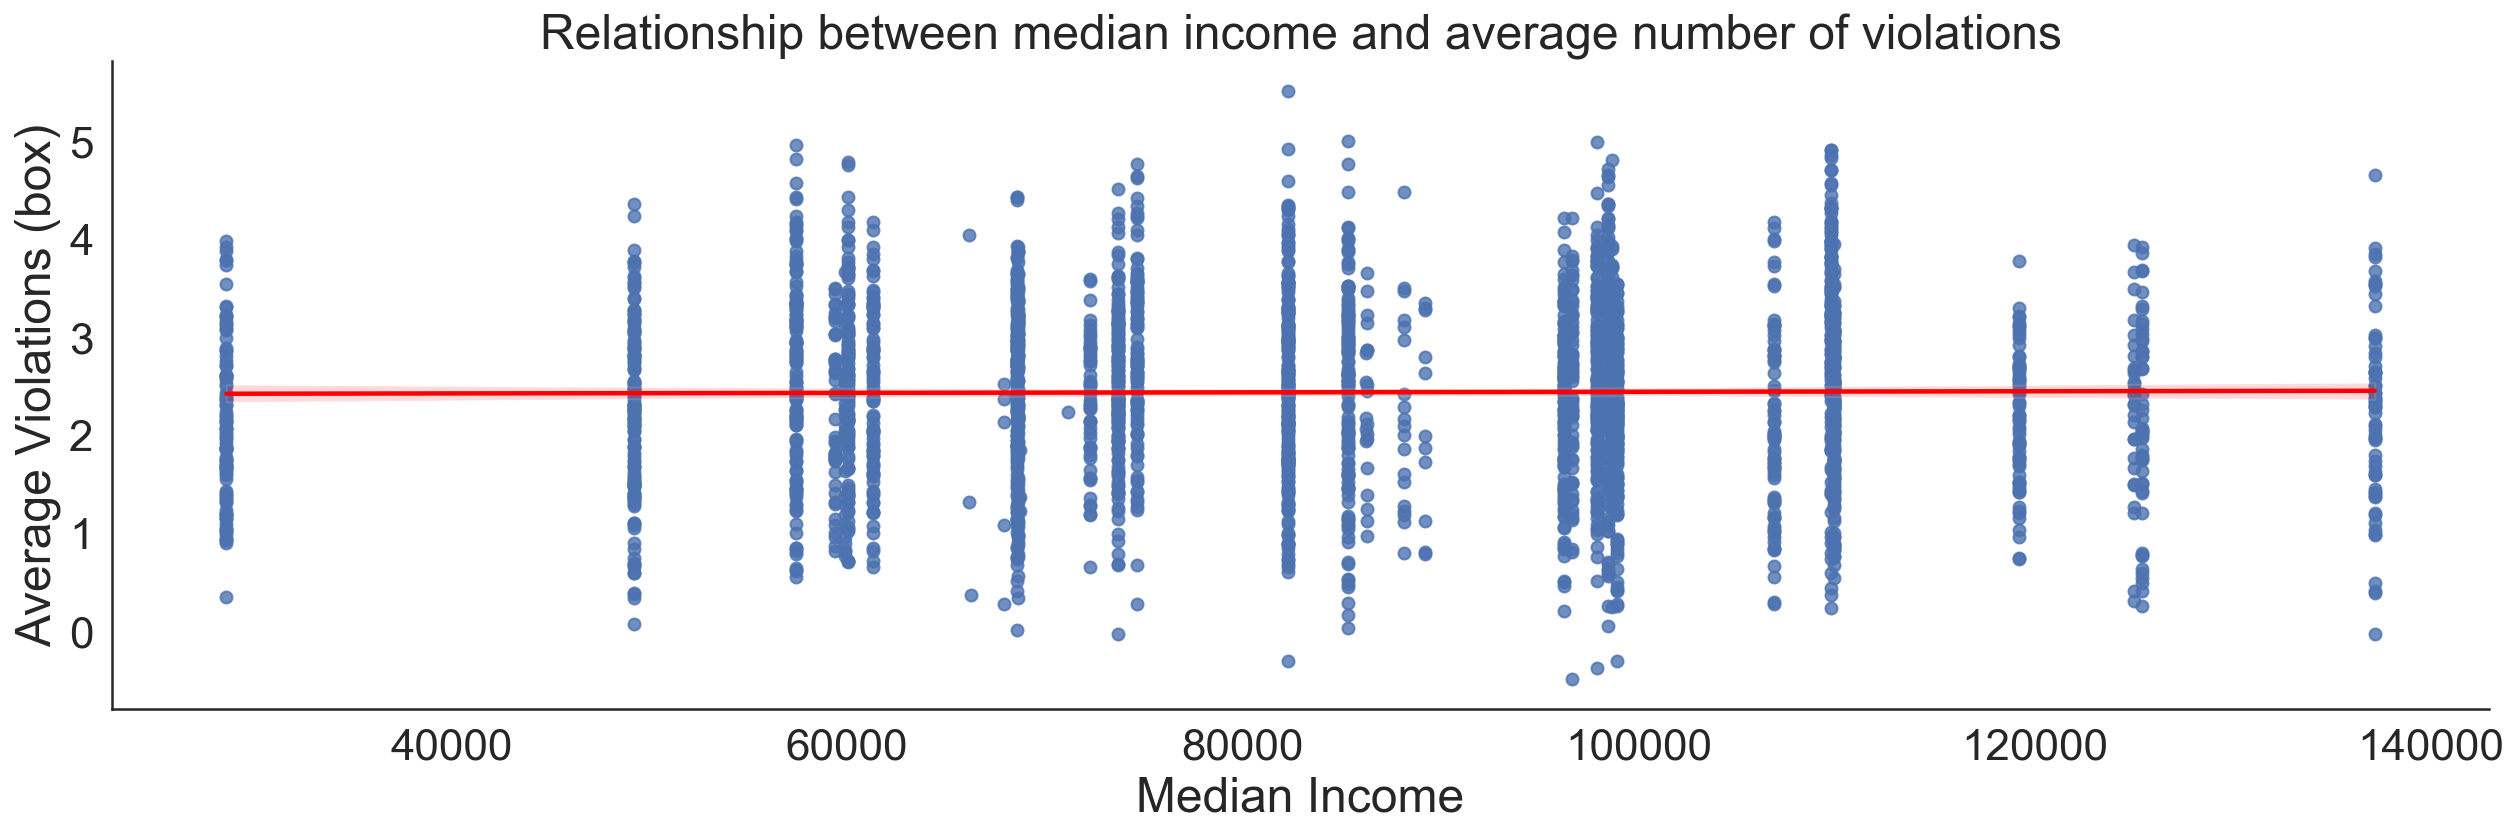

In [32]:
p = sns.lmplot(x='family', y='box_avg_violations', data=df, line_kws={'color': 'red'}, 
               height=6, aspect=3, x_jitter=.5, y_jitter=.5);
p = p.set_axis_labels("Median Income", "Average Violations (box)")
ax = plt.gca()
ax.set_title("Relationship between median income and average number of violations")


In [33]:
outcome, predictors = patsy.dmatrices('box_below_pov ~ box_avg_violations', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          box_below_pov   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5110
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.475
Time:                        18:48:38   Log-Likelihood:                -1793.1
No. Observations:                2783   AIC:                             3590.
Df Residuals:                    2781   BIC:                             3602.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6901      0

### Can't Reject the Null, Again
Our `p-value` is higher than the assumed `alpha=0.05` and therefore, we can't reject the null. Below we will plot the relationship and see the result with regression model, which shows no associations either.

Text(0.5, 1, 'Relationship between median income and average number of violations')

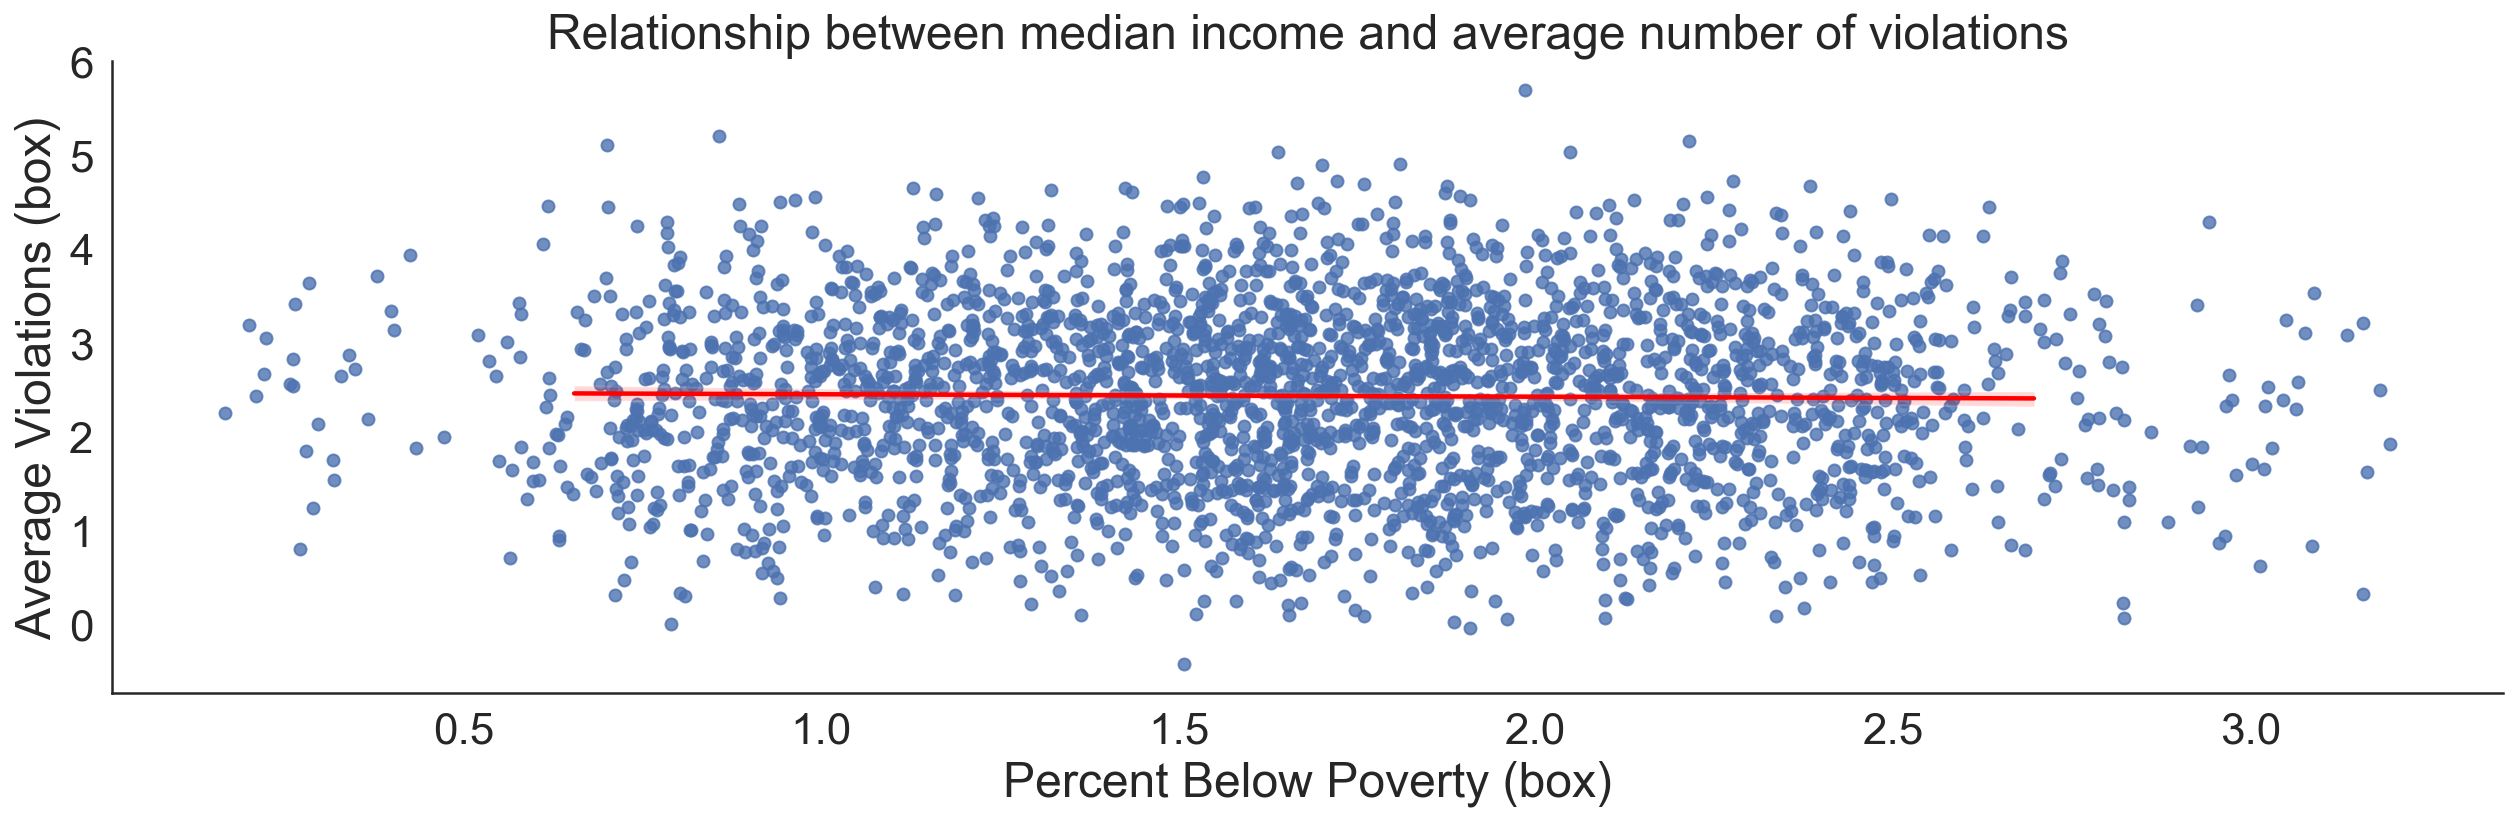

In [34]:
p = sns.lmplot(x='box_below_pov', y='box_avg_violations', data=df, line_kws={'color': 'red'}, height=6, aspect=3, x_jitter=.5, y_jitter=.5);

p = p.set_axis_labels("Percent Below Poverty (box)", "Average Violations (box)")
ax = plt.gca()
ax.set_title("Relationship between median income and average number of violations")



Below we plot relationship between **Non-white Percent and Average Violations** and see the result with regression model, which does not show any associations.

Text(0.5, 1, 'Relationship Non-white Percent and Average Violations')

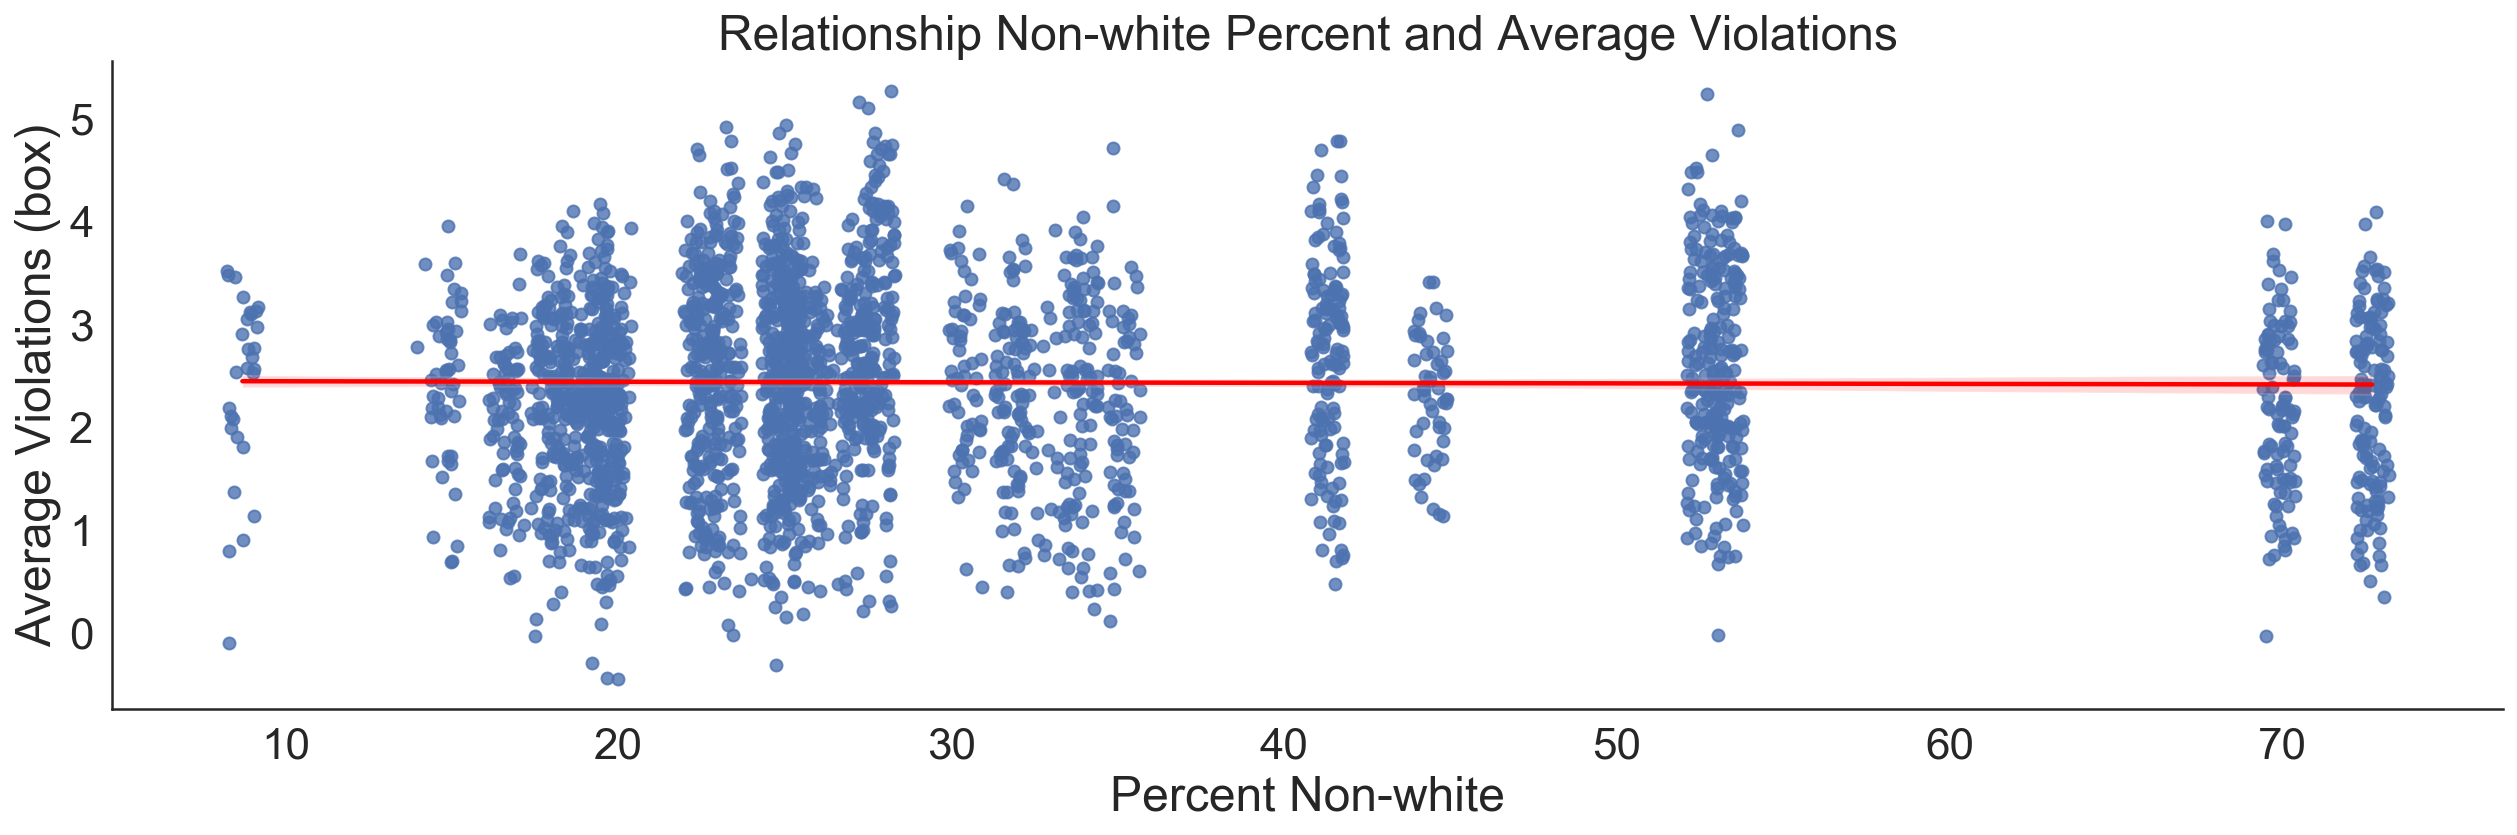

In [35]:
p = sns.lmplot(x='percent_nonwhite', y='box_avg_violations', data=df, line_kws={'color': 'red'}, height=6, aspect=3, x_jitter=.5, y_jitter=.5);

p = p.set_axis_labels("Percent Non-white", "Average Violations (box)")
ax = plt.gca()
ax.set_title("Relationship Non-white Percent and Average Violations")


Let's see if there is any relationships between **zip codes and average number of violations**.

In [36]:
outcome, predictors = patsy.dmatrices('zip ~ box_avg_violations', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                    zip   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.914
Date:                Wed, 10 Jun 2020   Prob (F-statistic):            0.00166
Time:                        18:48:41   Log-Likelihood:                -14286.
No. Observations:                2783   AIC:                         2.858e+04
Df Residuals:                    2781   BIC:                         2.859e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.758e+04      2

### Reject the Null
Our `p-value` is lower than the assumed `alpha=0.05` and therefore, we reject the null and look for more clues. We  use the `geopandas` package to visualize the zip codes by loading its `geojson` data and each business using their `x` and `y` coordinates.

In [37]:
# read the file again to get some dropped columns
tmp_df = pd.read_csv('data/inspections.csv')

# we only need the latest inspection row, so we filter by that value 
tmp_df = tmp_df.loc[tmp_df.groupby(['hsisid'], sort=False)['inspection_num'].idxmax()]

In [38]:
# some zip codes are missing from zipcodes.csv which contain income information.
# so we will filter out those missing rows here by comparing it with our main df
tmp_df = tmp_df[tmp_df['hsisid'].isin(df['hsisid'])]

# take useful columns
tmp_df = tmp_df[['hsisid', 'x', 'y', 'geocodestatus', 'zip']]

# create a geopandas Point from x and y coordinates
geo_insp = gpd.GeoDataFrame(tmp_df, geometry=gpd.points_from_xy(tmp_df.x, tmp_df.y))

In [39]:
# load geojson data for zip codes
geo_zips = gpd.read_file('data/new_zips.json')
geo_zips.rename({'ZIPNUM': 'zip'}, axis=1, inplace=True)

In [40]:
# merge the data
geo_zips = pd.merge(geo_zips, df, on='zip', how='left')

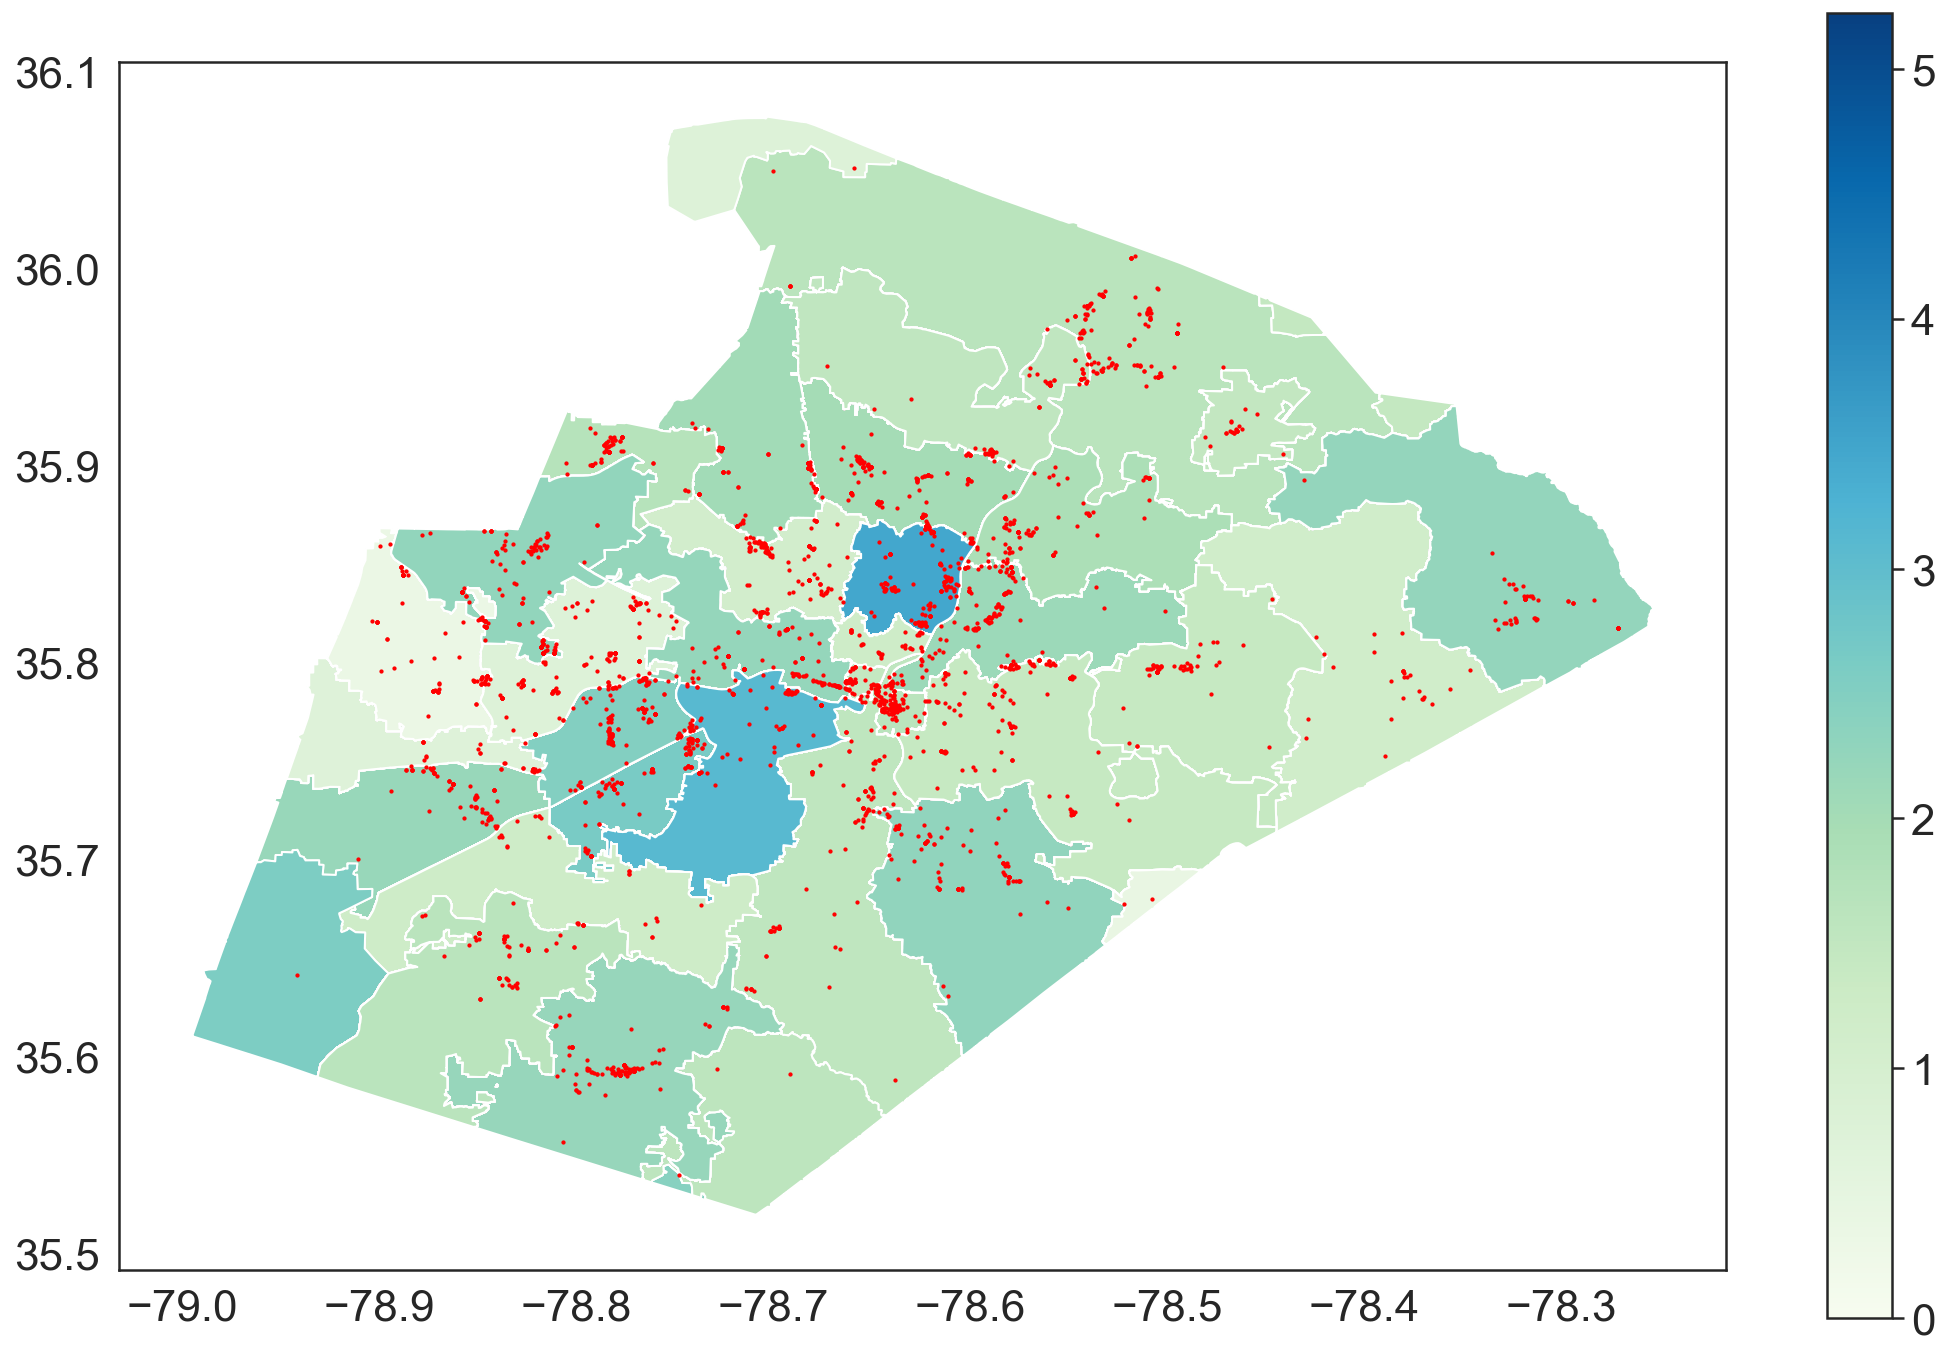

In [41]:
base = geo_zips.plot(column='box_avg_violations', figsize=(18, 12), cmap='GnBu', legend=True);
geo_insp.plot(ax=base, marker='.', color='red', markersize=5)

The above plot does not give us any more details about the relationship between zip code and average number of violations. It could help to use population for each zip code to to further analysis. However, for our current hypothesis, we did not find any relationship between lower income areas and higher violations average.

# Ethics & Privacy

-	We have to be careful to avoid the hypothesis to come in our way of collecting or analyzing data. This could take place in forms of fabricating data or altering the existing data to support our initial assumption. This also include accurate data collection. In this case, all data was provided or achieved from Wake county website, which is publicly available to everyone. We had to remove some columns and transform some variables to removed the skewedness. We didn't remove any information regarding a specific race, gender or that sort. 
-	We have to give credit to the owner of any data or resources we use and we should have the right to use their data for our study. 
-	There is no need to record or keep any identifiable information about the subjects and any such information that is included in a dataset has to be removed to maintain their anonymous status if the dataset is published on any online platform. We don't have any private information on our dataset that would violate any privacy laws. 



# Conclusion & Discussion
We started by asking if restaurants in low income neighborhoods have higher number of health violations? Based on previous studies, we know there is a relationship between an area's major ethnicities and races and what kind of businesses and quality of services they receive. There have been many studies on "socioeconomic, ethnic, and racial disparities in neighborhood access to fast-food outlets and convenience stores" and on relationship between socioeconomic status and risk of foodborne illness. [1], [2] Our hypothesis was that restaurants in low income areas are likely to have a higher average number of health code violations per inspection. We used the dataset provided by Wake county website on businesses inspections and income based on zipcodes. We added up critial and non-critical violations and created an average violations field for each business from their start date and transformed some columns to get rid of the skewedness in data. 


Our null hypothesis was that there is no relationship between median family income and average number of health code violations per inspection. The returned p-value was  higher than the assumed alpha=0.05 and therefore, we couldn't reject the null. We noticed that looking into relationships between zip codes and average number of violations, we received a small p-value. However, p-values don't indicate association automatically. We used the `geopandas` package to visualize the zip codes by loading its geojson data and each business using their x and y coordinates. There could be other underlying issues that might indicate higher average violations number such as, populate density. Determining the underlying factors will help us mitigate any inequities and improve public health. 

